In [1]:
# # importing the zipfile module
# from zipfile import ZipFile

# # loading the temp.zip and creating a zip object
# with ZipFile("/content/archive (6).zip", 'r') as zObject:

# 	# Extracting all the members of the zip
# 	# into a specific location.
# 	zObject.extractall(
# 		path="/content/")


In [61]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from IPython.display import display_html

import os

In [62]:
data_train = pd.read_csv('Forcasting_Dataset/DailyDelhiClimateTrain.csv',sep=',')
data_train.head()


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [63]:
data_train.shape

(1462, 5)

In [64]:
data_test = pd.read_csv('Forcasting_Dataset/DailyDelhiClimateTest.csv',sep=',')
data_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [65]:
data_test.shape

(114, 5)

In [66]:
data = pd.concat([data_train,data_test])
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [67]:
data.shape

(1576, 5)

In [68]:
data.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [69]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1010.593178
std,7.345014,16.979994,4.510725,175.242704
min,6.000000,13.428571,0.000000,-3.041667
25%,18.500000,49.750000,3.700000,1001.875000
50%,27.166667,62.440476,6.363571,1009.055556
75%,31.142857,72.125000,9.262500,1015.200000
max,38.714286,100.000000,42.220000,7679.333333


In [70]:
# Initial preprocessing and data visualization

In [71]:
data['date'] = pd.to_datetime(data['date'])

In [72]:
data = data.rename(columns={"meantemp":"temp","wind_speed":"wind","meanpressure":"pressure"})

In [73]:
data.head()

,date,temp,humidity,wind,pressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [74]:
print("Starting date of time series: ", data.date.min())
print("Final date of time series:    ", data.date.max())

Starting date of time series:  2013-01-01 00:00:00
Final date of time series:     2017-04-24 00:00:00


In [75]:
dates = data['date'].values
temp  = data['temp'].values
humidity = data['humidity'].values
wind = data['wind'].values
pressure = data['pressure'].values

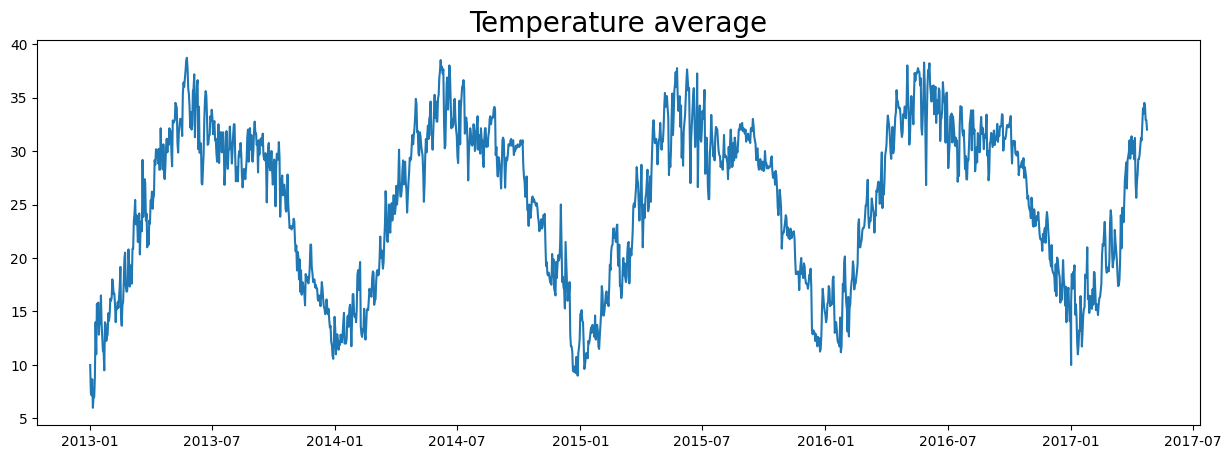

In [76]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

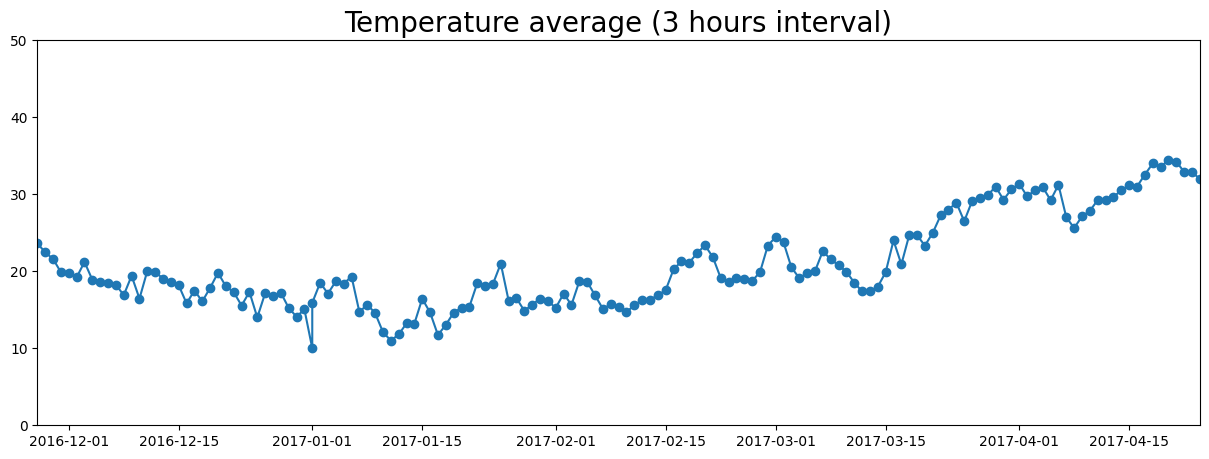

In [77]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp, 'o-')
plt.title('Temperature average (3 hours interval)', fontsize=20)
plt.axis([dates[-150],dates[-1],0,50]);

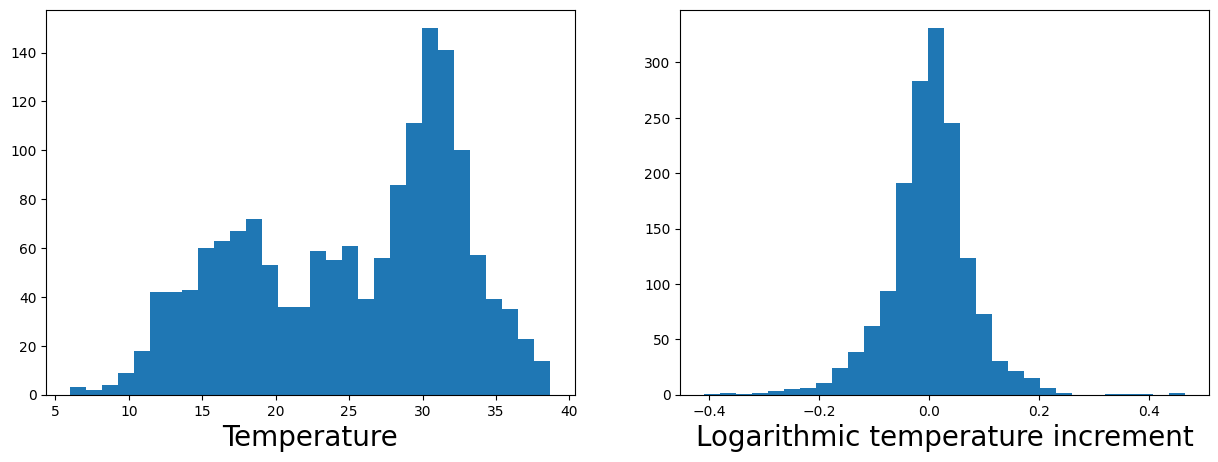

Temperature average                      : 25.221917636820887
Logarithmic temperature increment average: 0.000738508450670273


In [78]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(temp, bins=30)
plt.xlabel('Temperature', fontsize=20)
plt.subplot(1,2,2)
aux = np.log( temp[1:] / temp[0:-1]  )
plt.hist(aux, bins=30)
plt.xlabel('Logarithmic temperature increment', fontsize=20)
plt.show()
print("Temperature average                      :", temp.mean())
print("Logarithmic temperature increment average:", aux.mean())

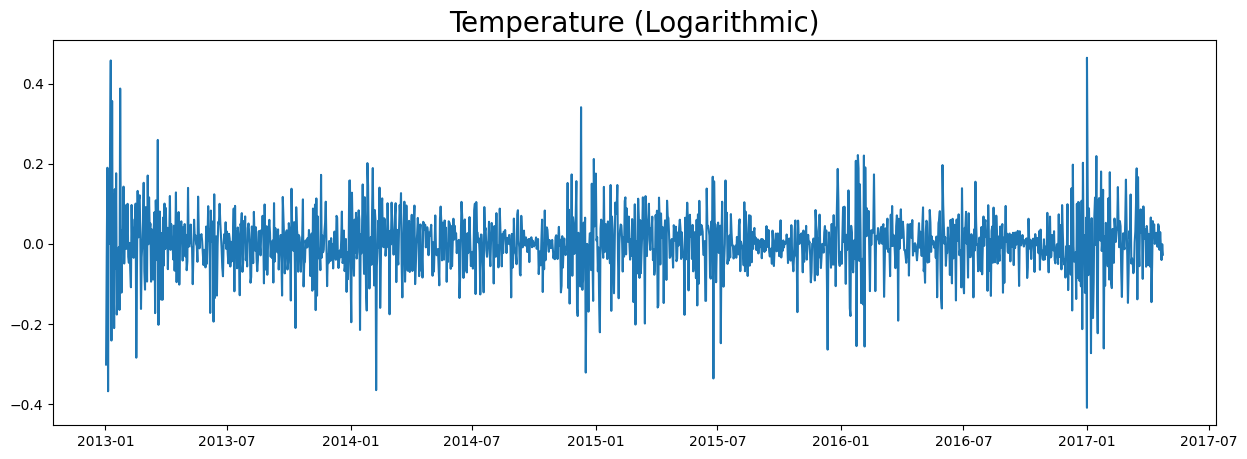

In [79]:
plt.figure(figsize=(15,5))
plt.plot(dates[1:], aux)
plt.title('Temperature (Logarithmic)',
          fontsize=20);

In [80]:
# Variable transformation

In [81]:
eps = 1e-11

NAN = np.NAN

# Logarithmic transformation

def transform_logratios(serie):
    aux = np.log((serie[1:]+eps) / (serie[0:-1]+eps))
    return np.hstack( ([NAN], aux))
def inverse_transform_logratios(log_ratio, temp_prev):
    return np.multiply(temp_prev, np.exp(log_ratio))

In [82]:
transform = transform_logratios
inverse_transform = inverse_transform_logratios

In [83]:
scaler = MinMaxScaler()
transformed = scaler.fit_transform(data.loc[:, ["humidity","wind","pressure"]])

In [84]:
transformed = pd.DataFrame(transformed, columns = ["humidity_s","wind_s","pressure_s"])
transformed.head()

,humidity_s,wind_s,pressure_s
0,0.820957,0.000000,0.132603
1,0.907591,0.070583,0.132881
2,0.849835,0.109743,0.132994
3,0.668867,0.029212,0.132799
4,0.847910,0.087636,0.132712


In [85]:
humidity_s = transformed['humidity_s'].values
wind_s = transformed['wind_s'].values
pressure_s = transformed['pressure_s'].values

In [86]:
#  Data winnowing

In [87]:
def winnowing(series, target, prev_known,
               W_in=1, W_out=1):
    n = len(series[0])
    dataX = NAN*np.ones((n,W_in,len(series)))
    if np.sometrue([s.dtype == object for s in series]):
        dataX = dataX.astype(object)
    if W_out==1:
        dataY = series[target].copy()
    else:
        dataY = NAN*np.ones((n,W_out))
        if series[target].dtype == object:
            dataY = dataY.astype(object)
        dataY[:,0] = series[target].copy()
        for i in range(1,W_out):
            dataY[:-i,i] = dataY[i:,0].copy()
    
    for i in range(n):
        for j,s in enumerate(prev_known):
            int_s = int(s) 
            ini_X = max([0,W_in-i-int_s])
            dataX[i, ini_X:,j] = \
            series[j][max([0,i-W_in+int_s]):min([n,i+int_s])]
    return dataX, dataY

In [88]:
def my_dfs_display(dfs,names):
    df_styler = []
    for df,n in zip(dfs,names):
        df_styler.append(df.style.set_table_attributes("style='display:inline'").\
                         set_caption(n))
    display_html(df_styler[0]._repr_html_()+"__"+df_styler[1]._repr_html_(),
                 raw=True)

In [89]:
def info_winnowing(X,Y,names_series,name_target,times=None):
    c0  = '\033[1m'  
    c1  = '\033[0m'  
    W_in = X.shape[1]
    if len(Y.shape)==1:
        W_out = 1
    else:
        W_out = Y.shape[1]
    print(len(X), "windows created \n")
    print("X.shape={}".format(X.shape)," Y.shape={}".format(Y.shape),"\n")
    for t in range(len(X)):
        print(c0,"Window %d:"%t, c1)
        if times is None:
            names_ts = ["t="+str(t+i-W_in) for i in range(W_in)]
            names_ts_pred = ["t="+str(t+i) for i in range(W_out)]
        else:
            times = list(times)
            if (t-W_in)<0:
                names_ts = ["?"+str(i) for i in range(W_in-t)] + times[:t]
            else:
                names_ts = times[(t-W_in):t]
            if (t+W_out-1)>=len(times):
                names_ts_pred = times[t:] + ["?"+str(i) for i in range(W_out-(len(times)-t))]
            else:
                names_ts_pred = times[t:(t+W_out)]
        aux1 = pd.DataFrame(X[t].T,columns=names_ts,index=names_series)
        aux2 = pd.DataFrame([Y[t]],columns=names_ts_pred,
                            index=[name_target])
        if W_out==1:
            my_dfs_display((aux1,aux2),
                           ("X[{}].shape={}".format(t,X[t].shape),
                            "Y[{}]={}".format(t,Y[t])))
        else:
            my_dfs_display((aux1,aux2),
                           ("X[{}].shape={}".format(t,X[t].shape),
                            "Y[{}].shape={}".format(t,Y[t].shape)))

In [90]:
logratio_temp = transform(temp)

series = [logratio_temp, humidity_s, wind_s, pressure_s]
prev_known = [False, False, False, False]

In [91]:
print(np.shape(series))
print(np.shape(prev_known))

(4, 1576)
(4,)


In [92]:
lookback = 6  # Window_in

X, y = winnowing (series, target=0, prev_known=prev_known,
                  W_in=lookback)

print(X.shape, np.shape(y))

(1576, 6, 4) (1576,)


In [93]:
info_winnowing(X[:20],y[:20],
                 names_series=["logratio_temp",
                                 "humidity_s", "wind_s",
                                 "pressure_s"],
                 name_target="logratio_temp",
                 times=dates)

20 windows created 

X.shape=(20, 6, 4)  Y.shape=(20,) 

 Window 0: 


X[0].shape=(6, 4) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 ?5 
 
 
 
 
 logratio_temp 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 humidity_s 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 wind_s 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 pressure_s 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 
__
 
 Y[0]=nan 
 
 
   
 2013-01-01 00:00:00 
 
 
 
 
 logratio_temp 
 nan

 Window 1: 


X[1].shape=(6, 4) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 ?4 
 2013-01-01T00:00:00.000000000 
 
 
 
 
 logratio_temp 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 humidity_s 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.820957 
 
 
 wind_s 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 
 
 pressure_s 
 nan 
 nan 
 nan 
 nan 
 nan 
 0.132603 
 
 
 
__
 
 Y[1]=-0.3011050927835701 
 
 
   
 2013-01-02 00:00:00 
 
 
 
 
 logratio_temp 
 -0.301105

 Window 2: 


X[2].shape=(6, 4) 
 
 
   
 ?0 
 ?1 
 ?2 
 ?3 
 2013-01-01T00:00:00.000000000 
 2013-01-02T00:00:00.000000000 
 
 
 
 
 logratio_temp 
 nan 
 nan 
 nan 
 nan 
 nan 
 -0.301105 
 
 
 humidity_s 
 nan 
 nan 
 nan 
 nan 
 0.820957 
 0.907591 
 
 
 wind_s 
 nan 
 nan 
 nan 
 nan 
 0.000000 
 0.070583 
 
 
 pressure_s 
 nan 
 nan 
 nan 
 nan 
 0.132603 
 0.132881 
 
 
 
__
 
 Y[2]=-0.03203935374457264 
 
 
   
 2013-01-03 00:00:00 
 
 
 
 
 logratio_temp 
 -0.032039

 Window 3: 


X[3].shape=(6, 4) 
 
 
   
 ?0 
 ?1 
 ?2 
 2013-01-01T00:00:00.000000000 
 2013-01-02T00:00:00.000000000 
 2013-01-03T00:00:00.000000000 
 
 
 
 
 logratio_temp 
 nan 
 nan 
 nan 
 nan 
 -0.301105 
 -0.032039 
 
 
 humidity_s 
 nan 
 nan 
 nan 
 0.820957 
 0.907591 
 0.849835 
 
 
 wind_s 
 nan 
 nan 
 nan 
 0.000000 
 0.070583 
 0.109743 
 
 
 pressure_s 
 nan 
 nan 
 nan 
 0.132603 
 0.132881 
 0.132994 
 
 
 
__
 
 Y[3]=0.19004360288762323 
 
 
   
 2013-01-04 00:00:00 
 
 
 
 
 logratio_temp 
 0.190044

 Window 4: 


X[4].shape=(6, 4) 
 
 
   
 ?0 
 ?1 
 2013-01-01T00:00:00.000000000 
 2013-01-02T00:00:00.000000000 
 2013-01-03T00:00:00.000000000 
 2013-01-04T00:00:00.000000000 
 
 
 
 
 logratio_temp 
 nan 
 nan 
 nan 
 -0.301105 
 -0.032039 
 0.190044 
 
 
 humidity_s 
 nan 
 nan 
 0.820957 
 0.907591 
 0.849835 
 0.668867 
 
 
 wind_s 
 nan 
 nan 
 0.000000 
 0.070583 
 0.109743 
 0.029212 
 
 
 pressure_s 
 nan 
 nan 
 0.132603 
 0.132881 
 0.132994 
 0.132799 
 
 
 
__
 
 Y[4]=-0.36772478012480436 
 
 
   
 2013-01-05 00:00:00 
 
 
 
 
 logratio_temp 
 -0.367725

 Window 5: 


X[5].shape=(6, 4) 
 
 
   
 ?0 
 2013-01-01T00:00:00.000000000 
 2013-01-02T00:00:00.000000000 
 2013-01-03T00:00:00.000000000 
 2013-01-04T00:00:00.000000000 
 2013-01-05T00:00:00.000000000 
 
 
 
 
 logratio_temp 
 nan 
 nan 
 -0.301105 
 -0.032039 
 0.190044 
 -0.367725 
 
 
 humidity_s 
 nan 
 0.820957 
 0.907591 
 0.849835 
 0.668867 
 0.847910 
 
 
 wind_s 
 nan 
 0.000000 
 0.070583 
 0.109743 
 0.029212 
 0.087636 
 
 
 pressure_s 
 nan 
 0.132603 
 0.132881 
 0.132994 
 0.132799 
 0.132712 
 
 
 
__
 
 Y[5]=0.15415067982702027 
 
 
   
 2013-01-06 00:00:00 
 
 
 
 
 logratio_temp 
 0.154151

 Window 6: 


X[6].shape=(6, 4) 
 
 
   
 2013-01-01 00:00:00 
 2013-01-02 00:00:00 
 2013-01-03 00:00:00 
 2013-01-04 00:00:00 
 2013-01-05 00:00:00 
 2013-01-06 00:00:00 
 
 
 
 
 logratio_temp 
 nan 
 -0.301105 
 -0.032039 
 0.190044 
 -0.367725 
 0.154151 
 
 
 humidity_s 
 0.820957 
 0.907591 
 0.849835 
 0.668867 
 0.847910 
 0.801320 
 
 
 wind_s 
 0.000000 
 0.070583 
 0.109743 
 0.029212 
 0.087636 
 0.035054 
 
 
 pressure_s 
 0.132603 
 0.132881 
 0.132994 
 0.132799 
 0.132712 
 0.132907 
 
 
 
__
 
 Y[6]=0.0 
 
 
   
 2013-01-07 00:00:00 
 
 
 
 
 logratio_temp 
 0.000000

 Window 7: 


X[7].shape=(6, 4) 
 
 
   
 2013-01-02 00:00:00 
 2013-01-03 00:00:00 
 2013-01-04 00:00:00 
 2013-01-05 00:00:00 
 2013-01-06 00:00:00 
 2013-01-07 00:00:00 
 
 
 
 
 logratio_temp 
 -0.301105 
 -0.032039 
 0.190044 
 -0.367725 
 0.154151 
 0.000000 
 
 
 humidity_s 
 0.907591 
 0.849835 
 0.668867 
 0.847910 
 0.801320 
 0.752805 
 
 
 wind_s 
 0.070583 
 0.109743 
 0.029212 
 0.087636 
 0.035054 
 0.149218 
 
 
 pressure_s 
 0.132881 
 0.132994 
 0.132799 
 0.132712 
 0.132907 
 0.133167 
 
 
 
__
 
 Y[7]=0.23531408693416545 
 
 
   
 2013-01-08 00:00:00 
 
 
 
 
 logratio_temp 
 0.235314

 Window 8: 


X[8].shape=(6, 4) 
 
 
   
 2013-01-03 00:00:00 
 2013-01-04 00:00:00 
 2013-01-05 00:00:00 
 2013-01-06 00:00:00 
 2013-01-07 00:00:00 
 2013-01-08 00:00:00 
 
 
 
 
 logratio_temp 
 -0.032039 
 0.190044 
 -0.367725 
 0.154151 
 0.000000 
 0.235314 
 
 
 humidity_s 
 0.849835 
 0.668867 
 0.847910 
 0.801320 
 0.752805 
 0.580858 
 
 
 wind_s 
 0.109743 
 0.029212 
 0.087636 
 0.035054 
 0.149218 
 0.169182 
 
 
 pressure_s 
 0.132994 
 0.132799 
 0.132712 
 0.132907 
 0.133167 
 0.133000 
 
 
 
__
 
 Y[8]=0.45783309362506563 
 
 
   
 2013-01-09 00:00:00 
 
 
 
 
 logratio_temp 
 0.457833

 Window 9: 


X[9].shape=(6, 4) 
 
 
   
 2013-01-04 00:00:00 
 2013-01-05 00:00:00 
 2013-01-06 00:00:00 
 2013-01-07 00:00:00 
 2013-01-08 00:00:00 
 2013-01-09 00:00:00 
 
 
 
 
 logratio_temp 
 0.190044 
 -0.367725 
 0.154151 
 0.000000 
 0.235314 
 0.457833 
 
 
 humidity_s 
 0.668867 
 0.847910 
 0.801320 
 0.752805 
 0.580858 
 0.436881 
 
 
 wind_s 
 0.029212 
 0.087636 
 0.035054 
 0.149218 
 0.169182 
 0.296068 
 
 
 pressure_s 
 0.132799 
 0.132712 
 0.132907 
 0.133167 
 0.133000 
 0.132777 
 
 
 
__
 
 Y[9]=-0.24116205681669323 
 
 
   
 2013-01-10 00:00:00 
 
 
 
 
 logratio_temp 
 -0.241162

 Window 10: 


X[10].shape=(6, 4) 
 
 
   
 2013-01-05 00:00:00 
 2013-01-06 00:00:00 
 2013-01-07 00:00:00 
 2013-01-08 00:00:00 
 2013-01-09 00:00:00 
 2013-01-10 00:00:00 
 
 
 
 
 logratio_temp 
 -0.367725 
 0.154151 
 0.000000 
 0.235314 
 0.457833 
 -0.241162 
 
 
 humidity_s 
 0.847910 
 0.801320 
 0.752805 
 0.580858 
 0.436881 
 0.561056 
 
 
 wind_s 
 0.087636 
 0.035054 
 0.149218 
 0.169182 
 0.296068 
 0.175272 
 
 
 pressure_s 
 0.132712 
 0.132907 
 0.133167 
 0.133000 
 0.132777 
 0.132603 
 
 
 
__
 
 Y[10]=0.3566749439384596 
 
 
   
 2013-01-11 00:00:00 
 
 
 
 
 logratio_temp 
 0.356675

 Window 11: 


X[11].shape=(6, 4) 
 
 
   
 2013-01-06 00:00:00 
 2013-01-07 00:00:00 
 2013-01-08 00:00:00 
 2013-01-09 00:00:00 
 2013-01-10 00:00:00 
 2013-01-11 00:00:00 
 
 
 
 
 logratio_temp 
 0.154151 
 0.000000 
 0.235314 
 0.457833 
 -0.241162 
 0.356675 
 
 
 humidity_s 
 0.801320 
 0.752805 
 0.580858 
 0.436881 
 0.561056 
 0.437294 
 
 
 wind_s 
 0.035054 
 0.149218 
 0.169182 
 0.296068 
 0.175272 
 0.250389 
 
 
 pressure_s 
 0.132907 
 0.133167 
 0.133000 
 0.132777 
 0.132603 
 0.132665 
 
 
 
__
 
 Y[11]=-0.11551288712176634 
 
 
   
 2013-01-12 00:00:00 
 
 
 
 
 logratio_temp 
 -0.115513

 Window 12: 


X[12].shape=(6, 4) 
 
 
   
 2013-01-07 00:00:00 
 2013-01-08 00:00:00 
 2013-01-09 00:00:00 
 2013-01-10 00:00:00 
 2013-01-11 00:00:00 
 2013-01-12 00:00:00 
 
 
 
 
 logratio_temp 
 0.000000 
 0.235314 
 0.457833 
 -0.241162 
 0.356675 
 -0.115513 
 
 
 humidity_s 
 0.752805 
 0.580858 
 0.436881 
 0.561056 
 0.437294 
 0.699670 
 
 
 wind_s 
 0.149218 
 0.169182 
 0.296068 
 0.175272 
 0.250389 
 0.313325 
 
 
 pressure_s 
 0.133167 
 0.133000 
 0.132777 
 0.132603 
 0.132665 
 0.132591 
 
 
 
__
 
 Y[12]=0.12306009275714454 
 
 
   
 2013-01-13 00:00:00 
 
 
 
 
 logratio_temp 
 0.123060

 Window 13: 


X[13].shape=(6, 4) 
 
 
   
 2013-01-08 00:00:00 
 2013-01-09 00:00:00 
 2013-01-10 00:00:00 
 2013-01-11 00:00:00 
 2013-01-12 00:00:00 
 2013-01-13 00:00:00 
 
 
 
 
 logratio_temp 
 0.235314 
 0.457833 
 -0.241162 
 0.356675 
 -0.115513 
 0.123060 
 
 
 humidity_s 
 0.580858 
 0.436881 
 0.561056 
 0.437294 
 0.699670 
 0.713146 
 
 
 wind_s 
 0.169182 
 0.296068 
 0.175272 
 0.250389 
 0.313325 
 0.109743 
 
 
 pressure_s 
 0.133000 
 0.132777 
 0.132603 
 0.132665 
 0.132591 
 0.132300 
 
 
 
__
 
 Y[13]=-0.21007146974670937 
 
 
   
 2013-01-14 00:00:00 
 
 
 
 
 logratio_temp 
 -0.210071

 Window 14: 


X[14].shape=(6, 4) 
 
 
   
 2013-01-09 00:00:00 
 2013-01-10 00:00:00 
 2013-01-11 00:00:00 
 2013-01-12 00:00:00 
 2013-01-13 00:00:00 
 2013-01-14 00:00:00 
 
 
 
 
 logratio_temp 
 0.457833 
 -0.241162 
 0.356675 
 -0.115513 
 0.123060 
 -0.210071 
 
 
 humidity_s 
 0.436881 
 0.561056 
 0.437294 
 0.699670 
 0.713146 
 0.863311 
 
 
 wind_s 
 0.296068 
 0.175272 
 0.250389 
 0.313325 
 0.109743 
 0.014606 
 
 
 pressure_s 
 0.132777 
 0.132603 
 0.132665 
 0.132591 
 0.132300 
 0.132538 
 
 
 
__
 
 Y[14]=0.13677288654859387 
 
 
   
 2013-01-15 00:00:00 
 
 
 
 
 logratio_temp 
 0.136773

 Window 15: 


X[15].shape=(6, 4) 
 
 
   
 2013-01-10 00:00:00 
 2013-01-11 00:00:00 
 2013-01-12 00:00:00 
 2013-01-13 00:00:00 
 2013-01-14 00:00:00 
 2013-01-15 00:00:00 
 
 
 
 
 logratio_temp 
 -0.241162 
 0.356675 
 -0.115513 
 0.123060 
 -0.210071 
 0.136773 
 
 
 humidity_s 
 0.561056 
 0.437294 
 0.699670 
 0.713146 
 0.863311 
 0.674917 
 
 
 wind_s 
 0.175272 
 0.250389 
 0.313325 
 0.109743 
 0.014606 
 0.012519 
 
 
 pressure_s 
 0.132603 
 0.132665 
 0.132591 
 0.132300 
 0.132538 
 0.132628 
 
 
 
__
 
 Y[15]=-0.06173770060573621 
 
 
   
 2013-01-16 00:00:00 
 
 
 
 
 logratio_temp 
 -0.061738

 Window 16: 


X[16].shape=(6, 4) 
 
 
   
 2013-01-11 00:00:00 
 2013-01-12 00:00:00 
 2013-01-13 00:00:00 
 2013-01-14 00:00:00 
 2013-01-15 00:00:00 
 2013-01-16 00:00:00 
 
 
 
 
 logratio_temp 
 0.356675 
 -0.115513 
 0.123060 
 -0.210071 
 0.136773 
 -0.061738 
 
 
 humidity_s 
 0.437294 
 0.699670 
 0.713146 
 0.863311 
 0.674917 
 0.845985 
 
 
 wind_s 
 0.250389 
 0.313325 
 0.109743 
 0.014606 
 0.012519 
 0.000000 
 
 
 pressure_s 
 0.132665 
 0.132591 
 0.132300 
 0.132538 
 0.132628 
 0.132733 
 
 
 
__
 
 Y[16]=0.17627924233787523 
 
 
   
 2013-01-17 00:00:00 
 
 
 
 
 logratio_temp 
 0.176279

 Window 17: 


X[17].shape=(6, 4) 
 
 
   
 2013-01-12 00:00:00 
 2013-01-13 00:00:00 
 2013-01-14 00:00:00 
 2013-01-15 00:00:00 
 2013-01-16 00:00:00 
 2013-01-17 00:00:00 
 
 
 
 
 logratio_temp 
 -0.115513 
 0.123060 
 -0.210071 
 0.136773 
 -0.061738 
 0.176279 
 
 
 humidity_s 
 0.699670 
 0.713146 
 0.863311 
 0.674917 
 0.845985 
 0.778603 
 
 
 wind_s 
 0.313325 
 0.109743 
 0.014606 
 0.012519 
 0.000000 
 0.124349 
 
 
 pressure_s 
 0.132591 
 0.132300 
 0.132538 
 0.132628 
 0.132733 
 0.132625 
 
 
 
__
 
 Y[17]=-0.17627924233787526 
 
 
   
 2013-01-18 00:00:00 
 
 
 
 
 logratio_temp 
 -0.176279

 Window 18: 


X[18].shape=(6, 4) 
 
 
   
 2013-01-13 00:00:00 
 2013-01-14 00:00:00 
 2013-01-15 00:00:00 
 2013-01-16 00:00:00 
 2013-01-17 00:00:00 
 2013-01-18 00:00:00 
 
 
 
 
 logratio_temp 
 0.123060 
 -0.210071 
 0.136773 
 -0.061738 
 0.176279 
 -0.176279 
 
 
 humidity_s 
 0.713146 
 0.863311 
 0.674917 
 0.845985 
 0.778603 
 0.909516 
 
 
 wind_s 
 0.109743 
 0.014606 
 0.012519 
 0.000000 
 0.124349 
 0.211985 
 
 
 pressure_s 
 0.132300 
 0.132538 
 0.132628 
 0.132733 
 0.132625 
 0.132451 
 
 
 
__
 
 Y[18]=-0.10135249426021042 
 
 
   
 2013-01-19 00:00:00 
 
 
 
 
 logratio_temp 
 -0.101352

 Window 19: 


X[19].shape=(6, 4) 
 
 
   
 2013-01-14 00:00:00 
 2013-01-15 00:00:00 
 2013-01-16 00:00:00 
 2013-01-17 00:00:00 
 2013-01-18 00:00:00 
 2013-01-19 00:00:00 
 
 
 
 
 logratio_temp 
 -0.210071 
 0.136773 
 -0.061738 
 0.176279 
 -0.176279 
 -0.101352 
 
 
 humidity_s 
 0.863311 
 0.674917 
 0.845985 
 0.778603 
 0.909516 
 0.730473 
 
 
 wind_s 
 0.014606 
 0.012519 
 0.000000 
 0.124349 
 0.211985 
 0.139349 
 
 
 pressure_s 
 0.132538 
 0.132628 
 0.132733 
 0.132625 
 0.132451 
 0.133384 
 
 
 
__
 
 Y[19]=-0.10219094089646111 
 
 
   
 2013-01-20 00:00:00 
 
 
 
 
 logratio_temp 
 -0.102191

In [94]:
print(X.shape)
print(np.shape(temp))

(1576, 6, 4)
(1576,)


In [35]:
# Training and test sets

In [95]:
X_train = X[(lookback+1):len(data_train)]
y_train = y[(lookback+1):len(data_train)]
temp_train = temp[(lookback+1):len(data_train)]
temp_test  = temp[len(data_train):]
X_test  = X[len(data_train):]
y_test  = y[len(data_train):]

print(np.shape(temp_train))
print(np.shape(temp_test))

(1455,)
(114,)


In [96]:
temp_prev_train =  np.hstack(( [NAN], temp_train[:-1]))
temp_prev_test  =  np.hstack(( temp_train[-1:],
                                      temp_test[:-1]))
dates_train     = dates[(lookback+1):len(data_train)]
dates_test      = dates[len(data_train):]

In [97]:
print(X_train.shape, y_train.shape)

(1455, 6, 4) (1455,)


In [39]:
# Model with Keras

In [98]:
model = Sequential()
model.add(LSTM(10, input_shape=(lookback, X_train.shape[2]),
#              kernel_regularizer='l1'
              )
         )
model.add(Dense(1,
#                kernel_regularizer='l1'
               )
         )
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse']) # 'RMSprop'
# mean_absolute_error

import keras.backend as K
print(K.get_value(model.optimizer.lr))

0.001


In [99]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [100]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                600       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


In [101]:
def training_graphic(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse', fontsize=18)
    plt.xlabel('time', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['Training', 'Validation'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()


Epoch 1: val_mse improved from inf to 0.00467, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse improved from 0.00467 to 0.00465, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse improved from 0.00465 to 0.00461, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse improved from 0.00461 to 0.00455, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse did not improve from 0.00455

Epoch 1: val_mse did not improve from 0.00455

Epoch 1: val_mse improved from 0.00455 to 0.00443, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse improved from 0.00443 to 0.00443, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse did not improve from 0.00443

Epoch 1: val_mse did not improve from 0.00443

Epoch 1: val_mse improved from 0.00443 to 0.00434, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse did not improve from 0.00434

Epoch 1: val_mse did not improve from 0.00434

Epoch 1: val_mse improved from 0.00434 to 0.00429, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse did not improve from 0.00429

Epoch 1: val_mse did not improve from 0.00429

Epoch 1: val_mse did not improve from 0.00429

Epoch 1: val_mse did not improve from 0.00429

Epoch 1: val_mse improved from 0.00429 to 0.00426, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse improved from 0.00426 to 0.00425, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse did not improve from 0.00425

Epoch 1: val_mse did not improve from 0.00425

Epoch 1: val_mse improved from 0.00425 to 0.00423, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val

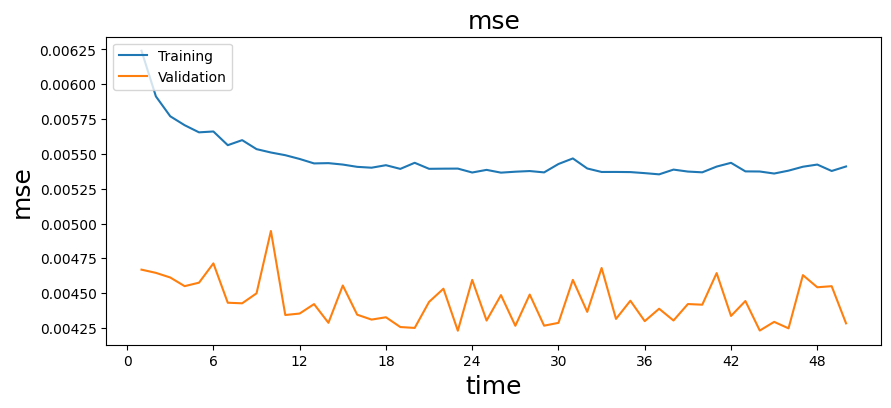


Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse did not improve from 0.00423

Epoch 1: val_mse improved from 0.00423 to 0.00421, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse improved from 0.00421 to 0.00419, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


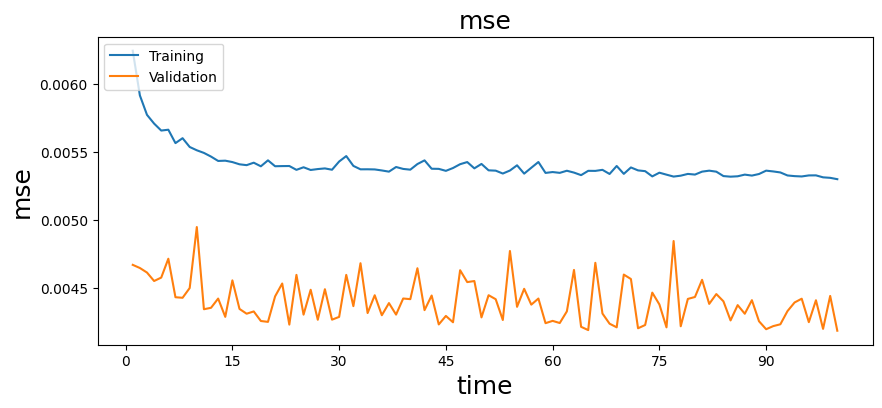


Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val_mse did not improve from 0.00419

Epoch 1: val

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418


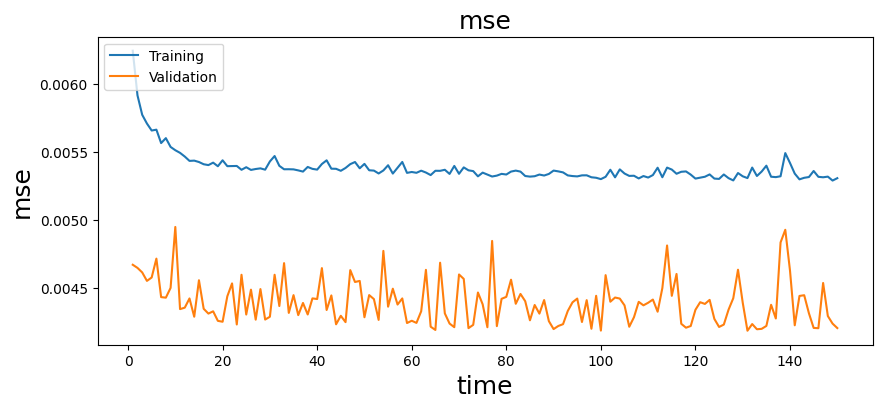


Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val_mse did not improve from 0.00418

Epoch 1: val

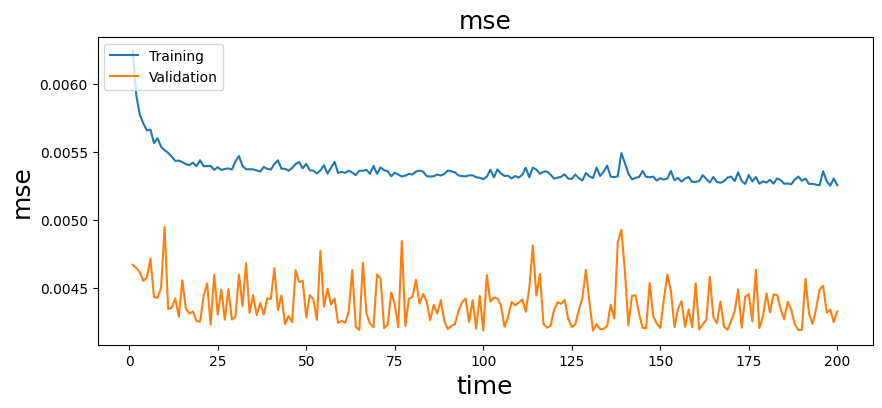

In [102]:
epochs = 200
batch_size = 64
Nval = 200
control_val = True
save_training_tensorboard = False


if not control_val:
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, verbose=2)
    
else:    
    acum_tr_mse = []
    acum_val_mse = []
    filepath="best_model"
    checkpoint = ModelCheckpoint(filepath, monitor='val_mse', verbose=2,
                                 save_best_only=True,
                                 mode='min')

    if save_training_tensorboard:
        callbacks_list = callbacks + [checkpoint]
    else:
        callbacks_list = [checkpoint]
    
    for e in range(epochs):
        history = model.fit(X_train[:-Nval], y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))
        
        acum_tr_mse  += history.history['mse']
        acum_val_mse += history.history['val_mse']
        
        if (e+1)%50 == 0:
            training_graphic(acum_tr_mse, acum_val_mse)

In [103]:
model.save('best.pt') 

INFO:tensorflow:Assets written to: best.pt/assets


INFO:tensorflow:Assets written to: best.pt/assets


In [48]:
y_train_prediction = model.predict(X_train).flatten()
y_test_prediction = model.predict(X_test).flatten()


4/4 [==============================] - 0s 5ms/step


In [49]:
temp_train_pred = inverse_transform(y_train_prediction,
                                          temp_prev_train)
temp_test_pred  = inverse_transform(y_test_prediction,
                                          temp_prev_test)

In [50]:
temp_train_pred

array([        nan,  8.62332669, 12.73814201, ..., 15.637445  ,
       14.73257796, 15.16393008])

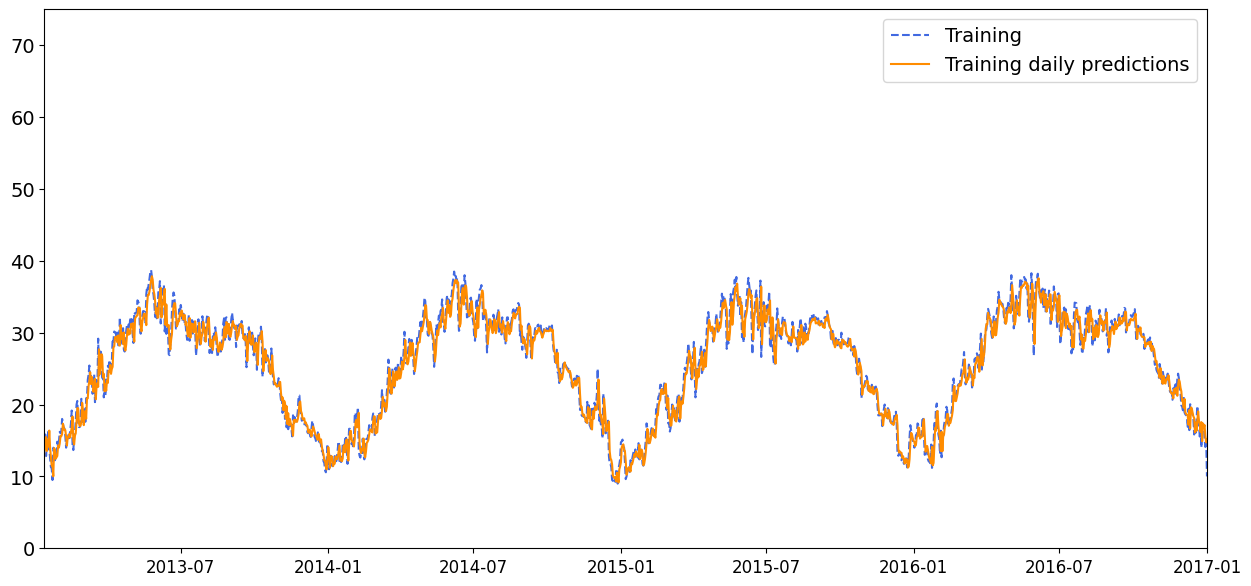

In [51]:
plt.figure(figsize=(15,7))
plt.plot(dates_train, temp_train, '--', c='royalblue',
         label="Training")
plt.plot(dates_train, temp_train_pred,  c='darkorange',
         label="Training daily predictions")

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([dates_train[4],dates_train[-1],0,75])
plt.legend(fontsize=14);

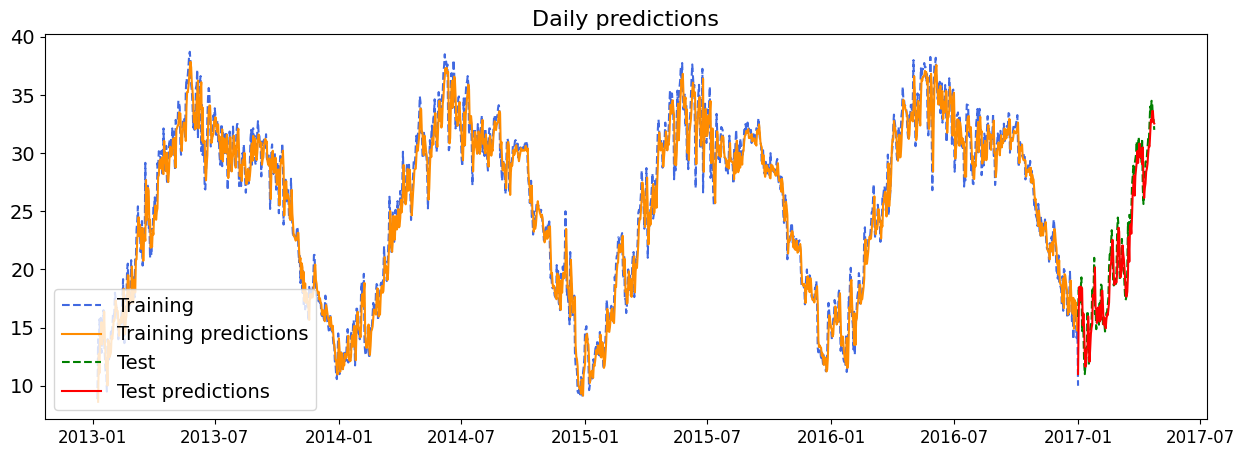

In [52]:
plt.figure(figsize=(15,5))
plt.plot(dates_train, temp_train, '--', c='royalblue',
         label='Training')
plt.plot(dates_train, temp_train_pred,  c='darkorange',
         label='Training predictions')
plt.plot(dates_test, temp_test, '--',   c='green',
         label='Test')
plt.plot(dates_test, temp_test_pred,    c='red',
         label='Test predictions')
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.title('Daily predictions', fontsize=16)
plt.legend(fontsize=14);

In [53]:
# dates_test

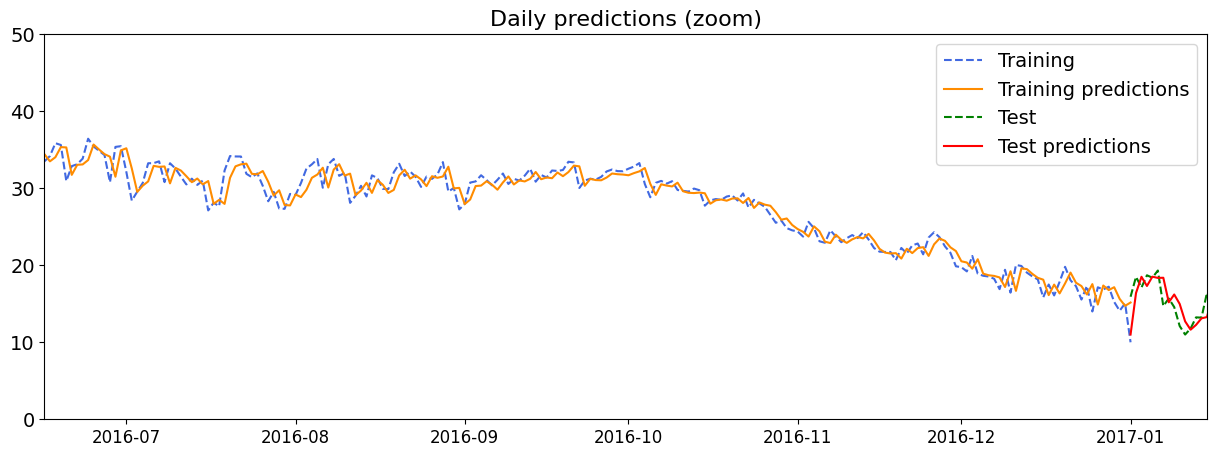

In [55]:
plt.figure(figsize=(15,5))
plt.plot(dates_train, temp_train, '--', c='royalblue',
         label='Training')
plt.plot(dates_train, temp_train_pred,  c='darkorange',
         label='Training predictions')
plt.plot(dates_test, temp_test, '--',   c='green',
         label='Test')
plt.plot(dates_test, temp_test_pred,    c='red',
         label='Test predictions')
plt.title('Daily predictions (zoom)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.axis([dates_train[-200],dates_test[-100],0,50]);

In [56]:
# R2 scores
print("R2 - Training      : ",
      R2_score(temp_train[1:], temp_train_pred[1:]))
print("R2 - Test          : ",
      R2_score(temp_test, temp_test_pred))
print("r2 - Interval 1 day     : ",
      R2_score(temp_test[1:], temp_test[:-1]))
print("R2 - Interval 1 week : ",
      R2_score(temp_test[7:], temp_test[:-7]))
print("R2 - Interval 4 weeks: ",
      R2_score(temp_test[28:], temp_test[:-28]))
print("R2 - Interval 1 year: ",
      R2_score(temp_train[7*52:], temp_train[:-7*52]))

R2 - Training      :  0.9509166874774503
R2 - Test          :  0.9236091997096023
r2 - Interval 1 day     :  0.9288700351758509
R2 - Interval 1 week :  0.6642995056919123
R2 - Interval 4 weeks:  -0.04835164773625156
R2 - Interval 1 year:  0.8076528137260894


In [57]:

# RMSEs
sqrt = np.sqrt
print("RMSE - Training      : ",
      sqrt(mean_squared_error(temp_train[1:],
                              temp_train_pred[1:])))
print("RMSE - Test          : ",
      sqrt(mean_squared_error(temp_test,
                              temp_test_pred)))
print("RMSE - Interval 1 day    : ",
      sqrt(mean_squared_error(temp_test[1:],
                              temp_test[:-1])))
print("RMSE - Interval 1 week : ",
      sqrt(mean_squared_error(temp_test[7:],
                              temp_test[:-7])))
print("RMSE - Interval 4 weeks: ",
      sqrt(mean_squared_error(temp_test[28:],
                              temp_test[:-28])))

RMSE - Training      :  1.605364231812407
RMSE - Test          :  1.7501261251793445
RMSE - Interval 1 day    :  1.6899351027215015
RMSE - Interval 1 week :  3.7250483900266014
RMSE - Interval 4 weeks:  6.083616713145777
